<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/nyu-deep-learning-2020/05_convolution_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolution neural network

In this notebook, we train a multilayer perceptron (FC network) and a convolution neural network (CNN) for the classification task on the MNIST dataset. 

Note that both networks have an equal number of parameters. 

**To perform well, we need to incorporate some prior knowledge about the problem**

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

**Reference**:

[ConvNet using PyTorch (CNN)](https://atcold.github.io/pytorch-Deep-Learning/en/week03/03-3/)

In [ ]:
!git clone https://github.com/Atcold/pytorch-Deep-Learning
!cp -r pytorch-Deep-Learning/res .
!rm -rf pytorch-Deep-Learning

In [8]:
# Load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import numpy as np
import random
import math

from IPython import display
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib.pyplot import plot, title, axis
from matplotlib import pyplot as plt

In [3]:
# Set style (needs to be in a new cell)
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# function to count number of parameters
def get_n_params(model):
  np = 0
  for p in list(model.parameters()):
    np += p.nelement()
  return np

##Loading the Dataset

Before training, we normalize our data so that the initialization of the network will match our data distribution (very important!). 

Also, make sure that the following five operations/steps are present in your training:

1. Feeding data to the model
2. Computing the loss
3. Cleaning the cache of accumulated gradients with `zero_grad()`
4. Computing the gradients
5. Performing a step in the optimizer method

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size = 28 * 28    # images are 28x28 pixels
output_size = 10        # there are 10 classes

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST("../data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))])),
  batch_size=64, 
  shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST("../data", train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))])),
  batch_size=1000, 
  shuffle=True
)

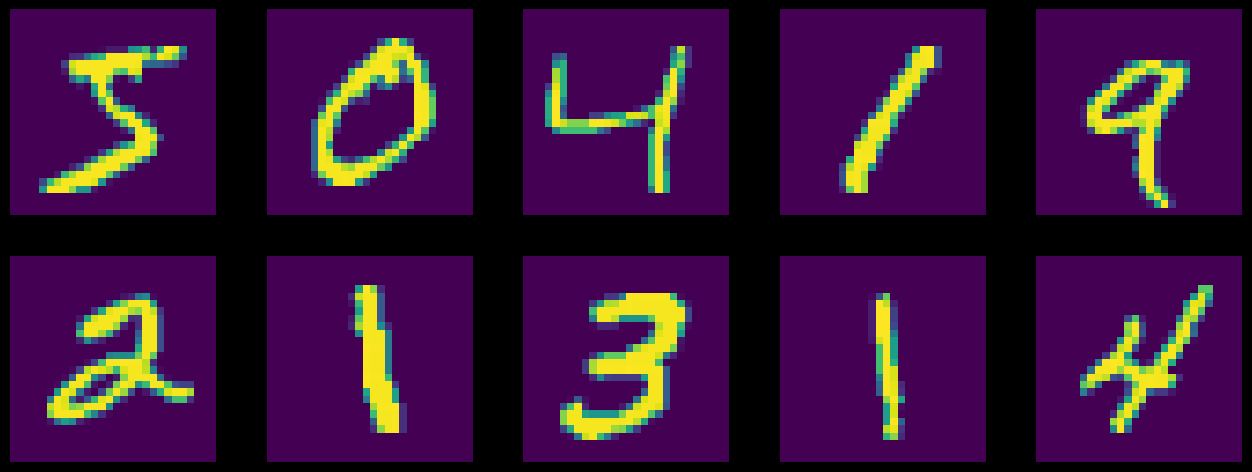

In [7]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  image, _ = train_loader.dataset.__getitem__(i)
  plt.imshow(image.squeeze().numpy())
  plt.axis("off");

First, we train both the networks on the normalized MNIST data.

## Creating the model classes

Let's define small fully-connected and ConvNet network.

In [16]:
class FCLayer(nn.Module):
  def __init__(self, input_size, n_hidden, output_size):
    super(FCLayer, self).__init__()

    self.input_size = input_size
    self.network = nn.Sequential(
      nn.Linear(input_size, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, n_hidden),
      nn.ReLU(),
      nn.Linear(n_hidden, output_size),
      nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = x.view(-1, self.input_size)
    return self.network(x)

In [9]:
class CNN(nn.Module):
  def __init__(self, input_size, n_feature, output_size):
    super(CNN, self).__init__()

    self.n_feature = n_feature 
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5)
    self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x, verbose=False):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = x.view(-1, self.n_feature * 4 * 4)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x

Let's define method for training and testing the model.

In [14]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # send to device
    data, target = data.to(device), target.to(device)
    
    # permute pixels
    data = data.view(-1, 28*28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

def test(model, perm=torch.arange(0, 784).long()):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    # send to device
    data, target = data.to(device), target.to(device)

    # permute pixels
    data = data.view(-1, 28 * 28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)

    output = model(data)

    test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1]   # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  accuracy_list.append(accuracy)
  print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")

##Training the model

First, we train both the networks on the normalized MNIST data. 

The accuracy of the FC network turned out to be 87% while the accuracy of the CNN turned out to be 95%. 

Given the same number of parameters, the CNN managed to train many more filters.

In [17]:
# let's train a small fully-connected network
n_hidden = 8

model_fnn = FCLayer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print(f"Number of parameters: {get_n_params(model_fnn)}")

for epoch in range(0, 1):
  train(epoch, model_fnn)
  test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.361889
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.972705
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.533777
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.197961
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.777783
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.789653
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.862780
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.622508
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.476778
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.574380

Test set: Average loss: 0.5055, Accuracy: 8503/10000 (85%)



In [18]:
# let's train a ConvNet with the same number of parameters
n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print(f"Number of parameters: {get_n_params(model_cnn)}")

for epoch in range(0, 1):
  train(epoch, model_cnn)
  test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.292208
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.662925
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.428567
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.470345
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.323818
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.259378
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.298829
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.283145
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.200066
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.141944

Test set: Average loss: 0.1736, Accuracy: 9479/10000 (95%)



In the FC network, filters that try to get some dependencies between things that are further away with things that are close by, are trained. They are completely wasted. 

Instead, in the convolutional network, all these parameters concentrate on the relationship between neighbour pixels.

**The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images.**

* **Use of convolution**: Locality and stationarity in images
* **Pooling**: builds in some translation invariance

**What happens if the assumptions are no longer true?**

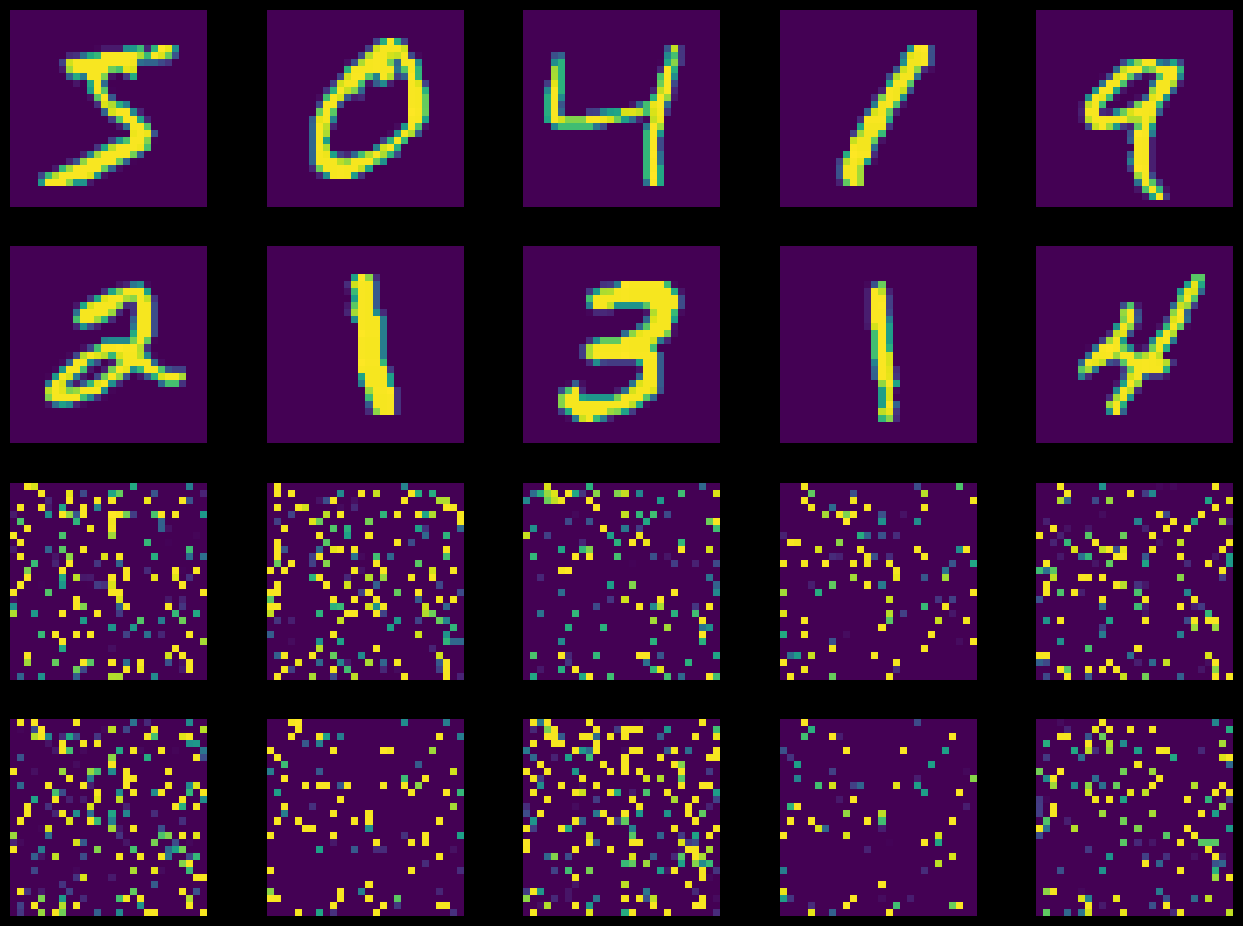

In [19]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
  image, _ = train_loader.dataset.__getitem__(i)
  # permute pixels
  image_perm = image.view(-1, 28*28).clone()
  image_perm = image_perm[:, perm]
  image_perm = image_perm.view(-1, 1, 28, 28)
  plt.subplot(4, 5, i + 1)
  plt.imshow(image.squeeze().numpy())
  plt.axis('off')
  plt.subplot(4, 5, i + 11)
  plt.imshow(image_perm.squeeze().numpy())
  plt.axis('off')

##Training model with permuted pixels

When we go from a linear model to one with two `nn.linear()` modules and a `nn.ReLU()` between them, then the model fit the data smoothly. 

This is because the regression become non-linear and adapt much better to this form of the data.

In [ ]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()

# use MSE for a regression task
criterion = torch.nn.MSELoss()

# create linear model with activation, each Linear module has a weight and bias
for mod in range(n_networks):
  model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU() if mod < n_networks // 2 else nn.Tanh(),
    nn.Linear(H, C),
  )
  model.to(device)

  # Append models
  models.append(model)

  # ADAM for our parameter updates
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

  # Training
  for epoch in range(1000):
    # Feed forward to get the logits
    y_pred = model(X)

    # Append pre-train output
    if epoch == 0:
      y_pretrain.append(y_pred.detach())

    # Compute the loss and accuracy
    loss = criterion(y_pred, y)

    print(f"[MODEL]: {mod + 1}, [EPOCH]: {epoch}, [LOSS]: {loss.item():.6f}")
    display.clear_output(wait=True)

    # zero the gradients before running the backward pass
    optimizer.zero_grad()

    # Backward pass to compute the gradient of loss w.r.t learnable params
    loss.backward()

    # Update params
    optimizer.step()

[MODEL]: 10, [EPOCH]: 999, [LOSS]: 0.010028


In [ ]:
# Plot trained model
print(models[0], models[-1])

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
) Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


##Predictions: Before Training

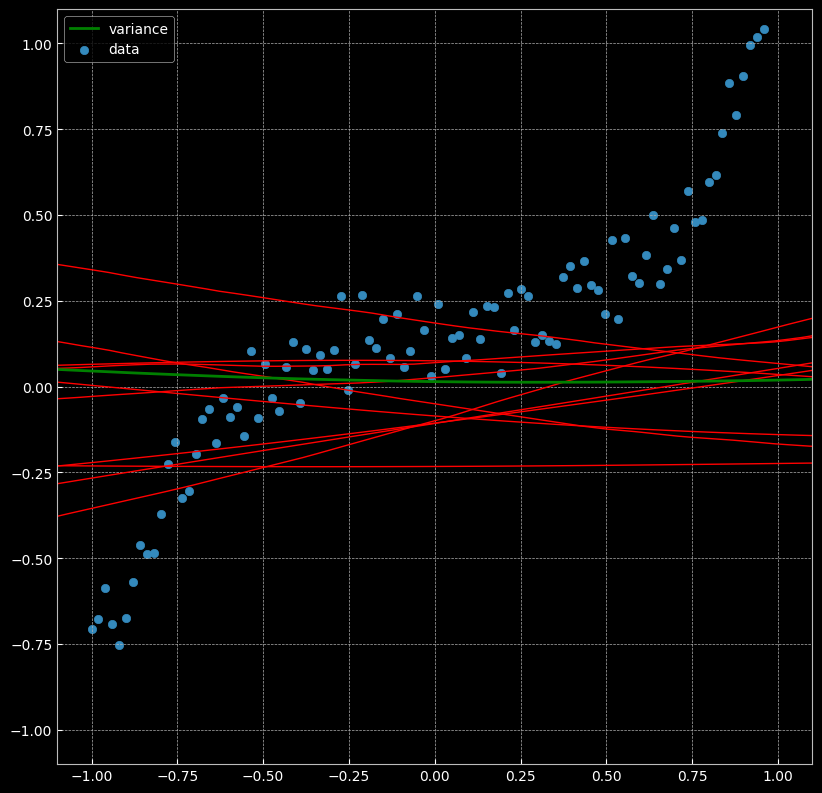

In [ ]:
for y_pretrain_idx in y_pretrain:
  # New X that ranges from -5 to 5 instead of -1 to 1
  x_new = torch.unsqueeze(torch.linspace(-2, 2, 100), dim=1)
  plt.plot(x_new.numpy(), y_pretrain_idx.cpu().numpy(), "r-", lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label="data")
plt.axis("square")
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(x_new.numpy(), y_combo.var(dim=0).cpu().numpy(), "g", label="variance")
plt.legend()
plt.show()

##Predictions: After Training

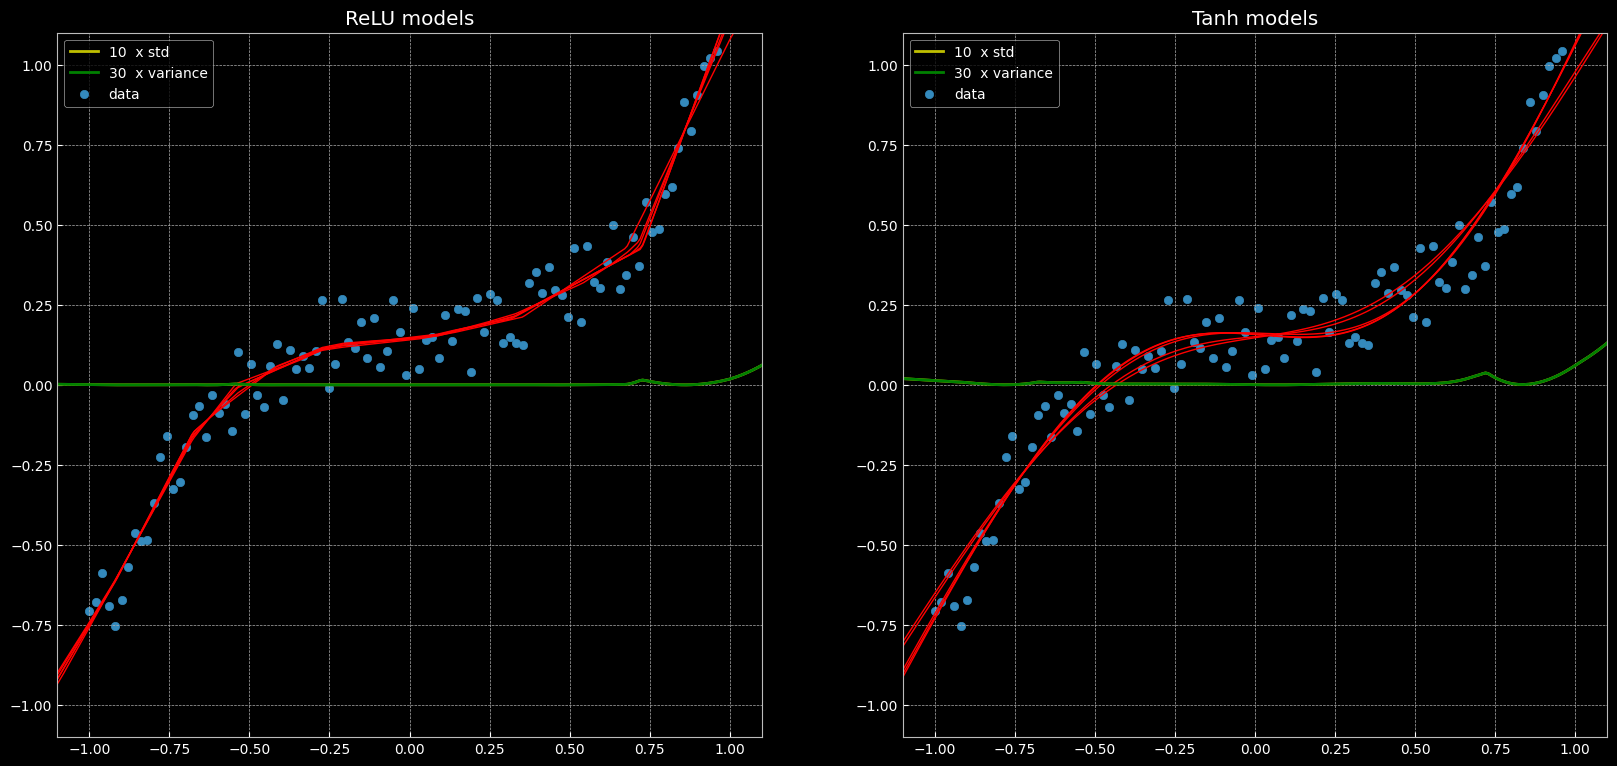

In [ ]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]

plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
  plt.subplot(1, 2, 1 if non_linearity == "ReLU" else 2)
  for model in models:
    # New X that ranges from -5 to 5 instead of -1 to 1
    x_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

    # Getting predictions from input
    with torch.no_grad():
      y_pred.append(model(x_new))
    
    plt.plot(x_new.cpu().numpy(), y_pred[-1].cpu().numpy(), "r-", lw=1)

  plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label="data")
  plt.axis("square")
  plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
  y_combo = torch.stack(y_pred)
  plt.plot(x_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), "y", label="10  x std")
  plt.plot(x_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), "g", label="30  x variance")
  plt.legend()
  plt.title(f"{non_linearity} models")

# try 1 or 4
z = 1
dense_prediction(relu_models, "ReLU", zoom=z)
dense_prediction(tanh_models, "Tanh", zoom=z)
plt.show()

As it shows 10 different networks, where 5 have a `nn.ReLU()` link function and 5 have a `nn.Tanh()`. 

The former is a piecewise linear function, whereas the latter is a continuous and smooth regression.

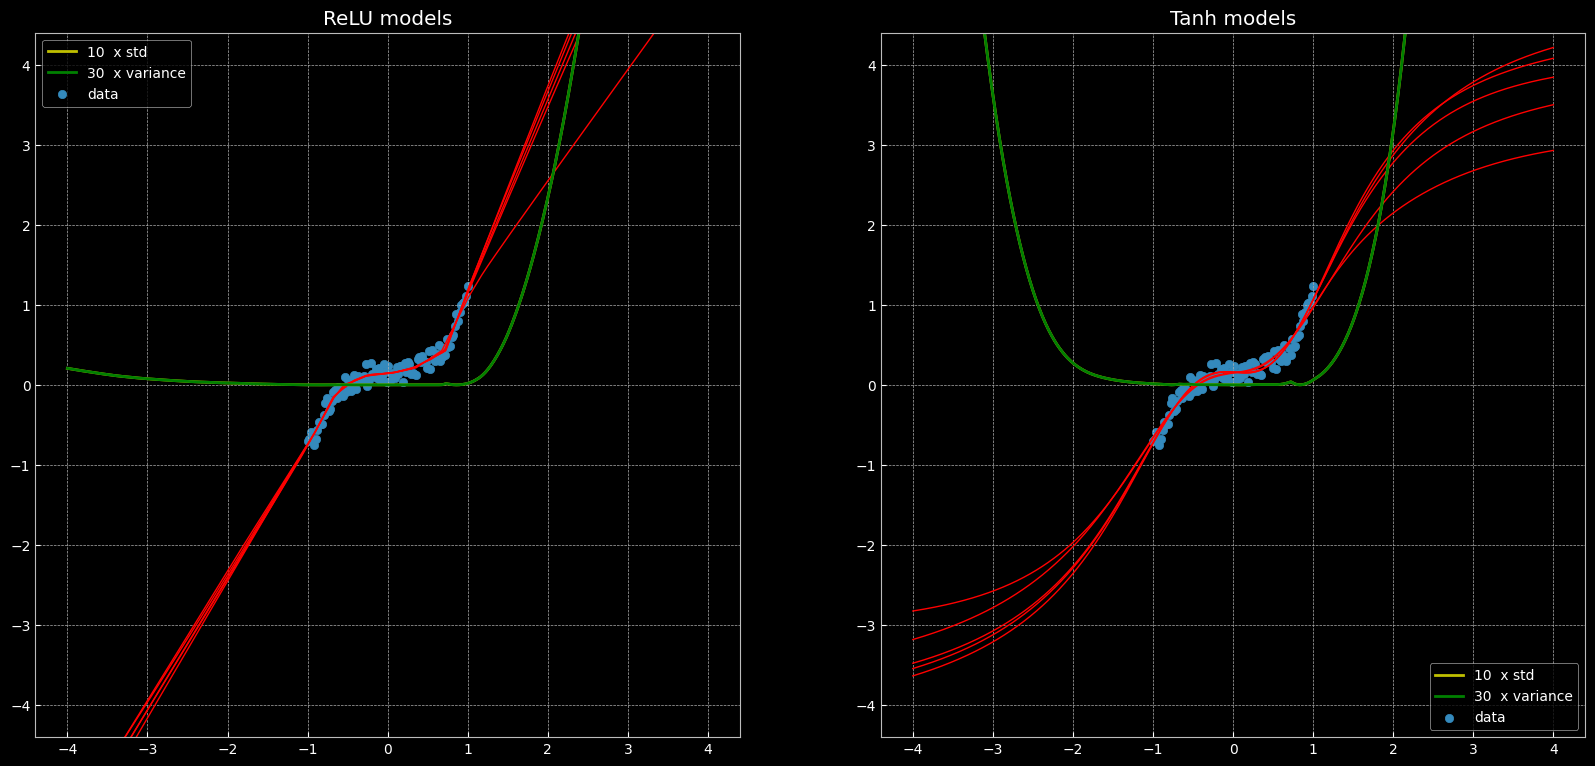

In [ ]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]

plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
  plt.subplot(1, 2, 1 if non_linearity == "ReLU" else 2)
  for model in models:
    # New X that ranges from -5 to 5 instead of -1 to 1
    x_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

    # Getting predictions from input
    with torch.no_grad():
      y_pred.append(model(x_new))
    
    plt.plot(x_new.cpu().numpy(), y_pred[-1].cpu().numpy(), "r-", lw=1)

  plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label="data")
  plt.axis("square")
  plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
  y_combo = torch.stack(y_pred)
  plt.plot(x_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), "y", label="10  x std")
  plt.plot(x_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), "g", label="30  x variance")
  plt.legend()
  plt.title(f"{non_linearity} models")

# try 1 or 4
z = 4
dense_prediction(relu_models, "ReLU", zoom=z)
dense_prediction(tanh_models, "Tanh", zoom=z)
plt.show()

The yellow and green lines show the standard deviation and variance for the networks. Using these is useful for something similar to a “confidence interval” – since the functions give a single prediction per output.

 Using ensemble variance prediction allows us to estimate the uncertainty with which the prediction is being made. The importance of this can be seen, where we extend the decision functions outside the training interval and these tend towards $+\infty, -\infty$.

##PyTorch 5 fundamental training steps

To train any Neural Network using PyTorch, you need 5 fundamental steps in the training loop:

1. `output = model(input)` is the model’s forward pass, which takes the input and generates the output.
2. `J = loss(output, target <or> label)` takes the model’s output and calculates the training loss with respect to the true target or label.
3. `model.zero_grad()` cleans up the gradient calculations, so that they are not accumulated for the next pass.
4. `J.backward()` does back-propagation and accumulation: It computes $\nabla_\texttt{x} J$ for every variable $\texttt{x}$ for which we have specified `requires_grad=True`. These are accumulated into the gradient of each variable: $\texttt{x.grad} \gets \texttt{x.grad} + \nabla_\texttt{x} J$.
5. `optimiser.step()` takes a step in gradient descent: $\vartheta \gets \vartheta - \eta\, \nabla_\vartheta J$.

When training a `NN`, it is very likely that you need these 5 steps in the order they were presented.